In [ ]:
#!pip install keras

In [ ]:
#!pip install tensorflow

In [69]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from termcolor import colored

# Read data from sentiment 140

In [70]:
sentiment = pd.read_csv("sentiment140.csv", encoding = "ISO-8859-1")
sentiment.columns=['polarity','tweetid','date','nq','author','tweet']
print (sentiment.shape) 
sentiment.head(2)

(1599999, 6)


,polarity,tweetid,date,nq,author,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [71]:
sentiment = sentiment.drop(["tweetid","date","nq","author"],axis=1)
sentiment.head(2)

,polarity,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...


# Understanding and Checking the dataset

In [72]:
sentiment.head(2)

,polarity,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...


In [73]:
sentiment.shape

(1599999, 2)

In [74]:
# Check for missing data
#traindata.isnull().values.any()
print("There is {} missing values in train data frame".format(sentiment.isnull().sum().sum()))

There is 0 missing values in train data frame


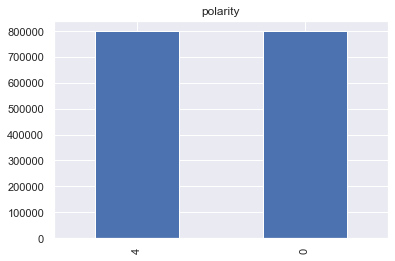

In [77]:
sentiment.polarity.value_counts().plot(kind="bar",subplots="True")
sns.set()
plt.show()

# Data Pre-Processing

In [102]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

def cleanText(s):
    bad_chars = [';', ':', '!', '*', '(' , ')', '&','[',']','.','?','{','}',',']
    non_ascii = "".join(i for i in s if ord(i)< 128)
    
    html_decoded_string = BeautifulSoup(non_ascii, "lxml")
    string = html_decoded_string.string
    
    non_name = " ".join((filter(lambda x:x[0]!='@', string.split())))
    non_badchars = ''.join(filter(lambda i: i not in bad_chars, non_name))
    non_links = re.sub(r"http\S+", "", non_badchars)
    non_websites = re.sub(r"www.[^ ]+","",non_links)
    non_numbers = re.sub(r"[0-9]+","",non_websites)
    
    clean = stopwords_stem(non_numbers)
    clean = decontracted(clean)
    
    return clean

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stopwords_stem(document): 
    words = word_tokenize(document)
    words = removeStopwords(words)
    words = stemWords(words)
    result = ""
    for word in words:
        result += word + " "
    return result

def removeStopwords(document):
    result = []
    for word in document:
        if word not in stop_words:
            result.append(word)
    return result

def stemWords(document):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    result = []
    for word in document:
        stem = stemmer.stem(word)
        result.append(stem)
    return result



## Cleaning tweets from dataframe and transform to list
#### Can skip if load from disk (below)

In [ ]:
tweets = sentiment.tweet
print("Cleaning Tweets: ")
tweets = [cleanText(t) for t in tqdm_notebook(tweets)]
polarity = sentiment.polarity

### Save the processed tweets for later use

In [ ]:
with open('tweets.pickle', 'wb') as f:
    pickle.dump(tweets, f)
with open('polarity.pickle', 'wb') as f:
    pickle.dump(polarity, f)

### Load from saved files

In [ ]:
with open('tweets.pickle', 'rb') as f:
    tweets = pickle.load(f)
with open('polarity.pickle', 'rb') as f:
    polarity = pickle.load(f)

In [ ]:
for i in range(5):
    print(sentiment.tweet[i])
    print(tweets[i]+"\n")

# Train/Test Split and save to csv file

In [ ]:
# Train test split
print(colored("Splitting train and test dataset into 80:20", "yellow"))
X_train, X_test, y_train, y_test = train_test_split(tweets, polarity, test_size = 0.2, random_state = 123)
train_dataset = pd.DataFrame({
    'Tweet': X_train,
    'Sentiment': y_train
    })
print(colored("Train data distribution:", "yellow"))
print(train_dataset['Sentiment'].value_counts())
test_dataset = pd.DataFrame({
    'Tweet': X_test,
    'Sentiment': y_test
    })
print(colored("Test data distribution:", "yellow"))
print(test_dataset['Sentiment'].value_counts())
print(colored("Split complete", "yellow"))

# Save train data
print(colored("Saving train data", "yellow"))

train_dataset.to_csv('train.csv', index = False)
print(colored("Train data saved to TrainTestSplitCSV/train.csv", "green"))

# Save test data
print(colored("Saving test data", "yellow"))
test_dataset.to_csv('test.csv', index = False)
print(colored("Test data saved to TrainTestSplitCSV/test.csv", "green"))

# TF-IDF Vectorizer

In [ ]:
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
print (train.shape)
train.head()

In [ ]:
test = pd.read_csv("test.csv")
print (test.shape)
test.head()

In [ ]:
# Check for missing data
#traindata.isnull().values.any()
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))
print("There is {} missing values in test data frame".format(test.isnull().sum().sum()))

In [ ]:
# Remove null from train data
train = train.dropna()
print("There is {} missing values in train data frame".format(train.isnull().sum().sum()))

In [ ]:
# Remove null from test data
test = test.dropna()
print("There is {} missing values in train data frame".format(test.isnull().sum().sum()))

In [ ]:
x_train = train['Tweet']
y_train = train['Sentiment']
x_test = test["Tweet"]
y_test = test['Sentiment']

In [ ]:
print (x_train.shape, x_test.shape)
print (y_train.shape, y_test.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

In [ ]:
print (train_vectors.shape)

# Exploring with Different Classifcation Models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import time
import csv

nb = MultinomialNB()
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_samples_leaf=50, random_state=13)
ada = AdaBoostClassifier(n_estimators=25)

models = {"Naive Bayes" : nb,
          "Logistic Regression" : lr,
          "Decision Tree" : dt,
          "AdaBoost" : ada}

# Open file to write result of various models 
csvFile = open("result.csv", 'w+', newline='')
writer = csv.writer(csvFile)
writer.writerow(('Model','Accuracy(train)','Accuracy(test)','Time'))

# iterate through all models

for key, value in models.items():   
    start_time = time.time()
    model = value

    # fit & predict training score
    model.fit(train_vectors, y_train)
    y_train_predict = model.predict(train_vectors)
    y_test_predict = model.predict(test_vectors)
    
    accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
    accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)

    print (key, 'testing accuracy', accuracy2)
    end_time = time.time()
    elapsed_time = round((end_time - start_time), 5)

    # Write result to file
    writer.writerow ((key, accuracy1, accuracy2, elapsed_time))

    # save the model to disk
    #filename = 'finalized_model.sav'
    filename = key + '_model.sav'
    pickle.dump(model, open(filename, 'wb'))

### CLOSE CSV FILE
csvFile.close()

# Visualising Testing, Training Accuracies and Traing Time

In [104]:
# Read result file from CSV
result = pd.read_csv("result.csv")

# sort by testing accuracy
print ('Sort by Testing Accuracy for the various models')
result.sort_values(by=["Accuracy(test)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

Sort by Testing Accuracy for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Logistic Regression,0.86310,0.80655,45.21095
Naive Bayes,0.89906,0.78872,1.17642
AdaBoost,0.67358,0.67328,206.82881
Decision Tree,0.61586,0.61624,63.97331


Graph showing the Testing Accuracy for the various models


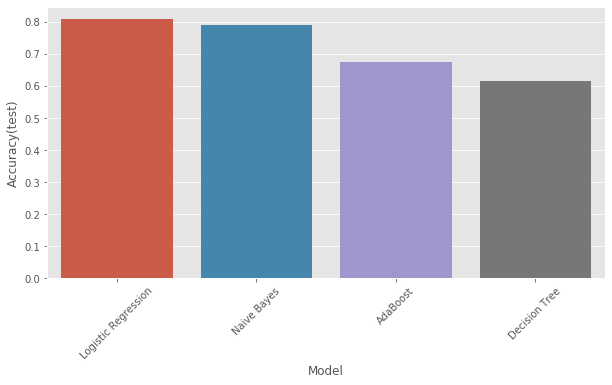

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot testing accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(test)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Testing Accuracy for the various models')

In [106]:
# sort by training accuracy
print ('Sort by Training Accuracy for the various models')
result.sort_values(by=["Accuracy(train)"], axis=0 ,ascending=False, inplace=True)
result.set_index('Model')

Sort by Training Accuracy for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89906,0.78872,1.17642
Logistic Regression,0.86310,0.80655,45.21095
AdaBoost,0.67358,0.67328,206.82881
Decision Tree,0.61586,0.61624,63.97331


Graph showing the Training Accuracy for the various models


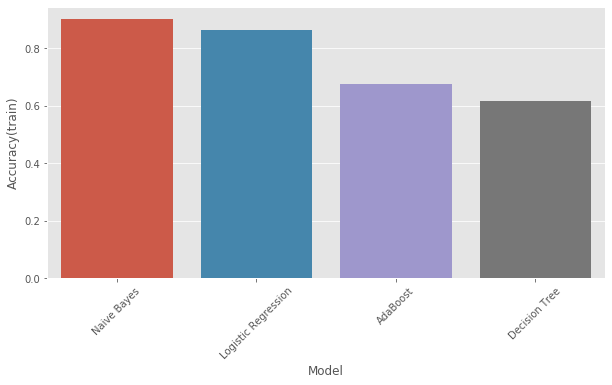

In [107]:
# Plot training accuracy for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Accuracy(train)"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the Training Accuracy for the various models')

#### The program shows that logistic regression classifier produces the best testing accuracy

In [108]:
# sort by timing
print ('Sort by Processing Time for the various models')
result.sort_values(by=["Time"], axis=0 ,ascending=True, inplace=True)
result.set_index('Model')

Sort by Processing Time for the various models


,Accuracy(train),Accuracy(test),Time
Model,,,
Naive Bayes,0.89906,0.78872,1.17642
Logistic Regression,0.86310,0.80655,45.21095
Decision Tree,0.61586,0.61624,63.97331
AdaBoost,0.67358,0.67328,206.82881


Graph showing the processing time for the various models


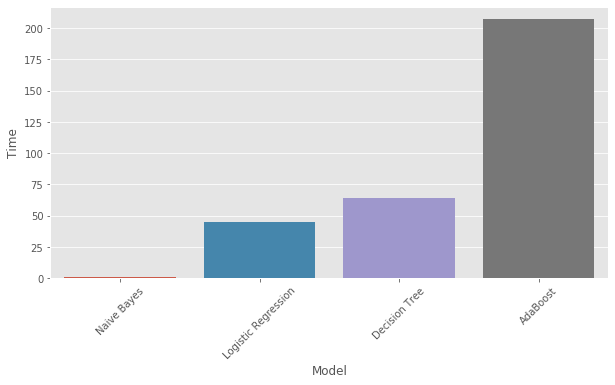

In [109]:
# Plot training time for various models
plt.figure(figsize=(10,5))
sns.barplot(x=result['Model'],y=result["Time"])
plt.xticks(rotation=45) # Rotation of model names
print ('Graph showing the processing time for the various models')

# Optimizing the Hyperparameters of Logistic Regression

In [ ]:
#Step 1 : determine the best solver
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lg = LogisticRegression( class_weight="balanced", random_state=42, max_iter=10000, penalty = 'l2')
grid = {'solver': ['liblinear', 'lbfgs', 'sag', 'saga']} # 
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

In [ ]:
#Step 2 : Using solver = liblinear, determine the best C value
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lg = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, penalty = 'l2')
grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

In [ ]:
#Step 3 : Fine tuning the C value 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

lg = LogisticRegression( class_weight="balanced", random_state=42, solver='liblinear', max_iter=10000, penalty = 'l2')
grid = {"C" : np.arange(0.5,2.51,0.1)}
lg_cv = GridSearchCV(lg, grid, cv=5)
lg_cv.fit(train_vectors, y_train)

# Print hyperparameter
print("Tuned hyperparameter parameters: {}".format(lg_cv.best_params_)) 
print("Best cross-validation score: {}".format(lg_cv.best_score_))

### The best hyperparameters are solver = liblinear and C = 1.8

# Cross Validation of Logistic Regression Model (SG)
https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79

Cross Validation is used to assess the predictive performance of the models and and to judge how they perform outside the sample to a new data set also known as test data. The motivation to use cross validation techniques is that when we fit a model, we are fitting it to a training dataset.

In [ ]:
# Cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(class_weight="balanced", random_state=42, 
                        solver='liblinear', max_iter=10000, C = 1.8, penalty= 'l2')

accuracies_lr = cross_val_score(estimator=lr, X=train_vectors, y=y_train, cv=10)
print("Logistic Regression Average accuracy: ", accuracies_lr.mean())
print("Logistic Regression Standard Deviation: ", accuracies_lr.std())

In [ ]:
# Using the best parameters to build and save model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
import csv

lr = LogisticRegression(class_weight="balanced", random_state=42, 
                        solver='liblinear', max_iter=10000, C = 1.8, penalty= 'l2')
print(lr)  

# fit & predict training score
model = lr.fit(train_vectors, y_train)
y_train_predict = model.predict(train_vectors)
y_test_predict = model.predict(test_vectors)
    
accuracy1 = round(accuracy_score(y_train, y_train_predict), 5)
accuracy2 = round(accuracy_score(y_test, y_test_predict), 5)
print ('Optimized Logistic Regression Training accuracy:', accuracy1)
print ('Optimized Logistic Regression Testing accuracy:', accuracy2)

print('Confusion metrics :\n', metrics.confusion_matrix(y_test, y_test_predict))

# save the model to disk
filename = 'lropt_model.sav'
pickle.dump(model, open(filename, 'wb'))


# Crawing of Tweet Data

In [ ]:
import pandas as pd
import tweepy
import spacy
consumer_key = "oYPnahnpntB67ZN6RwHQWJQg4"
consumer_secret = "ns9pmChOswLPesSMWzBq68BgwqXtRpx1eKe73f5SsYC78Bukp6"
access_token = "58218421-n2TD2tKbbLp5uvS2WnlfX82e3lVKCjh3UUvNvW217"
access_token_secret = "ILrE8AmSyjAQfa3yxK6eYHodBLfnguJQYrBHinzW5fH2C"
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

### Define Search Keywords

In [ ]:
search_words = 'ntu OR "nanyang technological university"'
#search_words = 'nus OR "national university of singapore"'
#search_words = 'smu OR "singapore management university"'
#filter retweets
search_words = search_words + " -filter:retweets"

num_records = 1500

### Call the search API

In [ ]:
tweets = tweepy.Cursor(api.search, q=search_words, lang="en",
            tweet_mode="extended", since_id="2001-01-01").items(num_records)

### Create Pandas Dataframe from results

In [ ]:
dlist = [[t.user.name,t.full_text,t.created_at,t.id] for t in tweets]
df = pd.DataFrame(data=dlist,columns=['user','tweet','date_tweet','tweet_id'])
print(df.shape)
df.head()

### Insert the new column (keyword) to the Dataframe and write to csv file

In [ ]:
df['keyword']="ntu,nanyang technological university"
#df['keyword']="nus,national university of singapore"
#df['keyword']="smu,singapore management university"

# write to csv
df.to_csv("ntu0.csv")
#df.to_csv("nus0.csv")
#df.to_csv("smu0.csv")

# Pre-processing of NTU, NUS & SMU Tweets

In [ ]:
#Reading tweets from NTU, NUS & SMU
import pandas as pd
import re
import pickle
from tqdm import tqdm_notebook

In [ ]:
ntu = pd.read_csv("ntu0.csv")
nus = pd.read_csv("nus0.csv")
smu = pd.read_csv("smu0.csv")
ntu = ntu.drop(["tweet_id", "keyword","user"],axis=1)
nus = nus.drop(["tweet_id","keyword","user"],axis=1)
smu = smu.drop(["tweet_id","keyword","user"],axis=1)
print (ntu.shape, nus.shape, smu.shape)
ntu.head()

In [ ]:
from tqdm import tqdm_notebook
ntutweets = ntu.tweet
nustweets = nus.tweet
smutweets = smu.tweet
print("Cleaning Tweets: ")
ntutweets = [cleanText(t) for t in tqdm_notebook(ntutweets)]
nustweets = [cleanText(t) for t in tqdm_notebook(nustweets)]
smutweets = [cleanText(t) for t in tqdm_notebook(smutweets)]
ntudate = ntu.date_tweet
nusdate = nus.date_tweet
smudate = smu.date_tweet


### Save tweets for use later

In [ ]:
#Save the processed tweets for later use
# save ntu tweets
with open('ntutweets.pickle', 'wb') as f:
    pickle.dump(ntutweets, f)
with open('ntudate.pickle', 'wb') as f:
    pickle.dump(ntudate, f)

# save nus tweets
with open('nustweets.pickle', 'wb') as f:
    pickle.dump(nustweets, f)
with open('nusdate.pickle', 'wb') as f:
    pickle.dump(nusdate, f)  

# save smu tweets
with open('smutweets.pickle', 'wb') as f:
    pickle.dump(smutweets, f)
with open('smudate.pickle', 'wb') as f:
    pickle.dump(smudate, f)    

### Load the tweets on various universities and saving to csv

In [ ]:
# Load ntu data
with open('ntutweets.pickle', 'rb') as f:
    ntutweets = pickle.load(f)
with open('ntudate.pickle', 'rb') as f:
    ntudate = pickle.load(f)
    
# Load nus data
with open('nustweets.pickle', 'rb') as f:
    nustweets = pickle.load(f)
with open('nusdate.pickle', 'rb') as f:
    nusdate = pickle.load(f)
    
# Load smu data
with open('smutweets.pickle', 'rb') as f:
    smutweets = pickle.load(f)
with open('smudate.pickle', 'rb') as f:
    smudate = pickle.load(f)

In [ ]:
### Saving tweets as dataframefrom termcolor import colored
# Save as dataframe
ntu_data = pd.DataFrame({
    'Tweet': ntutweets,
    'Date': ntudate
    })

nus_data = pd.DataFrame({
    'Tweet': nustweets,
    'Date': nusdate
    })

smu_data = pd.DataFrame({
    'Tweet': smutweets,
    'Date': smudate
    })

# Save data
print(colored("Saving data", "blue"))
ntu_data.to_csv('ntu_data.csv', index = False)
nus_data.to_csv('nus_data.csv', index = False)
smu_data.to_csv('smu_data.csv', index = False)
ntu_data.head()

# Classification of University Tweets

### Load the CSV files on various universities

In [1]:
import pandas as pd
import re
import csv
import pickle

ntu_data = pd.read_csv("ntu_data.csv")
print (ntu_data.shape)

nus_data = pd.read_csv("nus_data.csv")
print (nus_data.shape)

smu_data = pd.read_csv("smu_data.csv")
print (smu_data.shape)

(2383, 2)
(2818, 2)
(3000, 2)


In [2]:
# Remove null from ntu data

#df = df.dropna(axis=0, subset=['Charge_Per_Line'])
print("There is {} missing values in ntu data frame".format(ntu_data.isnull().sum().sum()))
ntu_data = ntu_data.dropna()
print (ntu_data.shape)

# Remove null from nus data
print("There is {} missing values in nus data frame".format(nus_data.isnull().sum().sum()))
nus_datadata = nus_data.dropna()
print (nus_data.shape)

# Remove null from smu data
print("There is {} missing values in smu data frame".format(smu_data.isnull().sum().sum()))
smu_data = smu_data.dropna()
print (smu_data.shape)

There is 3 missing values in ntu data frame
(2380, 2)
There is 0 missing values in nus data frame
(2818, 2)
There is 3 missing values in smu data frame
(2997, 2)


In [3]:
train = pd.read_csv("train.csv", encoding = "ISO-8859-1")
train = train.dropna()
x_train = train['Tweet']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
ngram = (1,2)
vectorizer = TfidfVectorizer(ngram_range = ngram)
train_vectors = vectorizer.fit_transform(x_train)
ntu_vectors = vectorizer.transform(ntu_data['Tweet'])
nus_vectors = vectorizer.transform(nus_data['Tweet'])
smu_vectors = vectorizer.transform(smu_data['Tweet'])

In [95]:
# May Be Better to combine all data into 1 data frame for ease of analysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import time
import csv

# load the model from disk
loaded_model = pickle.load(open('lropt_model.sav', 'rb'))
    
# classification on tweets data
print ('Classifying NTU Tweets')
ntu_y_test_predict = loaded_model.predict(ntu_vectors)

print ('Classifying NUS Tweets')
nus_y_test_predict = loaded_model.predict(nus_vectors)

print ('Classifying SMU Tweets')
smu_y_test_predict = loaded_model.predict(smu_vectors)
    
# Prepare analysis file
# NTU
ntu_data['Date'] = ntu_data['Date']
ntu_data['Sentiment'] = ntu_y_test_predict
ntu_data['Tweet'] = ntu_data['Tweet']
ntu_data['Uni'] = 1
ntu_submit = ntu_data[['Date', 'Sentiment', 'Tweet', 'Uni']]
ntu_submit.to_csv('ntu_sentiment.csv', index=False, header=True)

# NUS
nus_data['Date'] = nus_data['Date']
nus_data['Sentiment'] = nus_y_test_predict
nus_data['Tweet'] = nus_data['Tweet']
nus_data['Uni'] = 2
nus_submit = nus_data[['Date', 'Sentiment', 'Tweet', 'Uni']]
nus_submit.to_csv('nus_sentiment.csv', index=False, header=True)

# SMU
smu_data['Date'] = smu_data['Date']
smu_data['Sentiment'] = smu_y_test_predict
smu_data['Tweet'] = smu_data['Tweet']
smu_data['Uni'] = 3
smu_submit = smu_data[['Date', 'Sentiment', 'Tweet', 'Uni']]
smu_submit.to_csv('smu_sentiment.csv', index=False, header=True)

Classifying NTU Tweets
Classifying NUS Tweets
Classifying SMU Tweets


In [4]:
# merge ntu, nus & smu sentiments file
import pandas as pd

df1 = pd.read_csv('ntu_sentiment.csv')
df2 = pd.read_csv('nus_sentiment.csv')
df3 = pd.read_csv('smu_sentiment.csv')

df_combined = pd.concat([df1, df2, df3])
df_combined.to_csv('uni_sentiment.csv', index=None)
uni_sent = pd.read_csv("uni_sentiment.csv")
print (uni_sent.shape)
uni_sent.sample(10)

(8195, 4)


,Date,Sentiment,Tweet,Uni
8084,16/4/2020 12:48,4,from implement advanc edtech hold first ever v...,3
7303,17/4/2020 22:38,4,like teas jigen,3
535,5/2/2020 14:33,4,number ye read correctli ntu clear webbi close...,1
7417,17/4/2020 18:34,4,smu offer bridgeland TX QB conner weigman,3
1983,15/4/2020 14:47,0,are problem current system absolut the answer ...,1
6396,12/2/2020 6:00,4,from innov local eldercar empow children rescu...,3
4870,15/4/2020 0:19,0,Be fair employ drunk nu,2
5030,14/4/2020 5:53,0,all nu nc I hope understand guy camera not ple...,2
4527,16/4/2020 12:38,4,how malfeas B kelli nu ghani,2
931,3/2/2020 12:25,4,ntu alumna sarah elli acclaim author nothe sq...,1


# Summary of Sentiments from University Tweets

In [3]:
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def sent_plt(file, title):
    df = file
    x,y = 'Uni', 'Sentiment'
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    sns.set()
    g = sns.catplot(x=x,y='percent',hue=y, kind='bar',data=df1, palette='rainbow', height=5, aspect=2)
    g.ax.set_ylim(0,100)

    plt.title( title, fontsize=15)
    plt.xlabel('University')
    #plt.legend(title='Sentiment', loc='upper left', labels=['Negative', 'Postive'])

    #Replace the x-tick label
    g.ax.set_xticklabels(('NTU', 'NUS', 'SMU'), fontsize=10)

    # new legend title
    new_title = 'Sentiments'
    g._legend.set_title(new_title)

    # replace legend labels
    new_labels = ['negative', 'positive']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

    # displaying the percentage figure    
    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
    
    # placing the legend in top left hand corner
    leg = g._legend
    leg.set_bbox_to_anchor([0.1, .95])  # coordinates of lower left of bounding box
    leg._loc = 2
    return

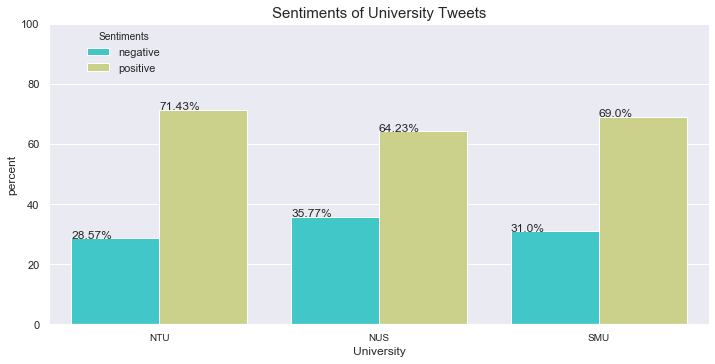

In [4]:
import datetime
df = pd.read_csv('uni_sentiment.csv')
sent_plt(df,'Sentiments of University Tweets')

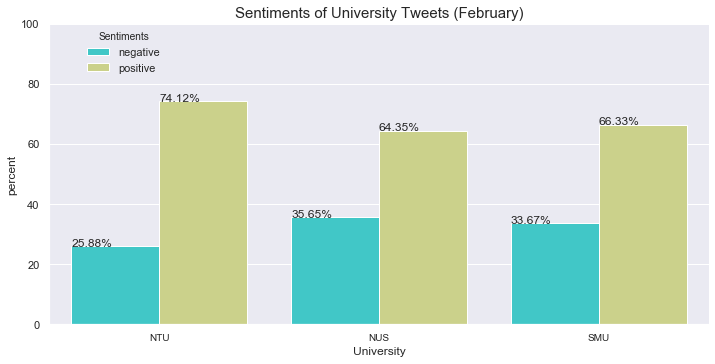

In [5]:
import datetime
df = pd.read_csv('uni_sentiment.csv')

# convert to string
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.strftime('%Y-%m') 

# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

# drop April 2020 data & plot 
df.drop(df[df['Date'] == '2020-04-01'].index,inplace=True)

sent_plt(df, 'Sentiments of University Tweets (February)')

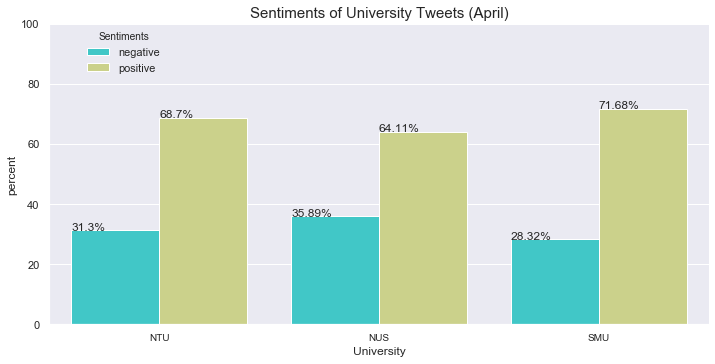

In [90]:
import datetime
df = pd.read_csv('uni_sentiment.csv')

# convert to string
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.strftime('%Y-%m') 

# convert to datetime
df['Date'] = pd.to_datetime(df['Date'])

# drop feburary 2020 data & plot 
df.drop(df[df['Date'] == '2020-02-01'].index,inplace=True)

sent_plt(df, 'Sentiments of University Tweets (April)')

# Time plot of Sentiment from the various Universities

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

def Time_Plot(file):
    df = pd.read_csv(file, encoding = "ISO-8859-1")

    #convert str into pd datetime
    #set index by date
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')
    df.set_index('Date', inplace=True)

#    print (df.head())    

    #count occurence of the 2 categories of sentiments by date using index.get_level_values() and .size()
    #assign name 'Count' to 'Size' column and re-align the columns to enable plotting
    fqc = df.groupby([df.index.get_level_values(0).date,df.Sentiment]).size().to_frame().reset_index()
    fqc.columns = ['Date','Category', 'Count']
    
    #convert to datetimeindex
    fqc['Date'] = pd.to_datetime(fqc['Date'], format='%Y-%m-%d %H:%M:%S') #to allow summing of count by Y, m, d
    fqc.set_index('Date', inplace=True)
    
    #use ggplot style
    plt.style.use('ggplot')
    #use pandas Grouper function to group and plot sum of counts for each rating category by month
    fqc_month = fqc.groupby([pd.Grouper(freq='D'), 'Category']).sum()\
                .reset_index().pivot(index='Date', columns='Category', values='Count')
    
    #display(fqc_month) #can see there are months with NaN values
    fqc_month.fillna(int('0')).plot(title= 'Sentiments', figsize=(10,5))
    plt.show()
    
    # plot comparing February 2020 tweets
    peak_fqc = fqc_month['2020-02-01': '2020-02-20']
    peak_fqc.fillna(int('0')).plot(figsize=(10,5), title = 'February 2020 Sentiment')
    plt.show()
    
    # plot comparing April 2020 tweets
    peak_fqc = fqc_month['2020-04-12': '2020-04-20']
    peak_fqc.fillna(int('0')).plot(figsize=(10,5), title = 'April 2020 Sentiment')
    plt.show()
    
    return 

Time plot of Sentiment from NTU


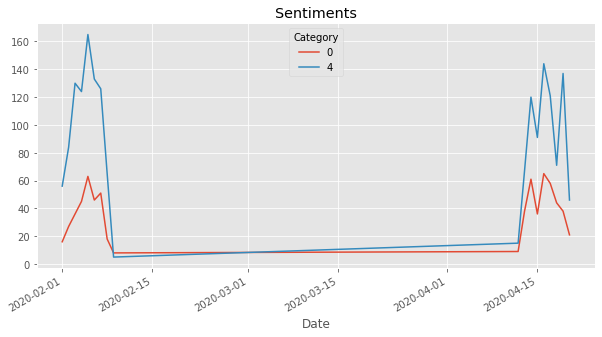

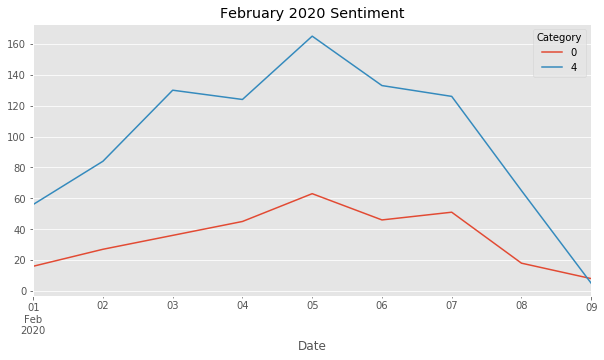

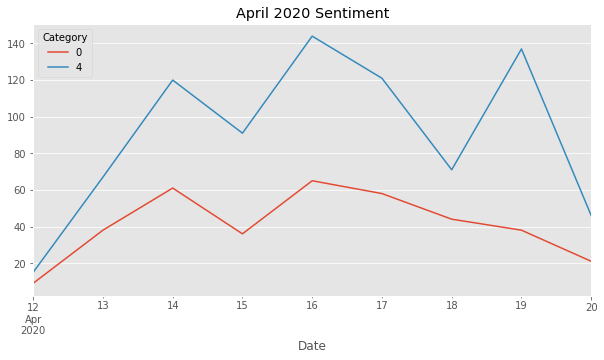

In [90]:
print ("\033[1m"+'Time plot of Sentiment from NTU'+"\033[0m")
Time_Plot('ntu_sentiment.csv')

Time plot of Sentiment from NUS


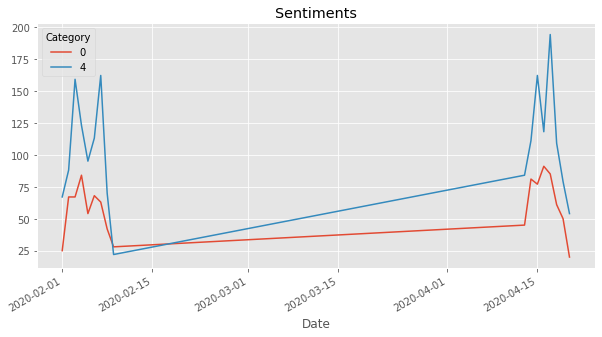

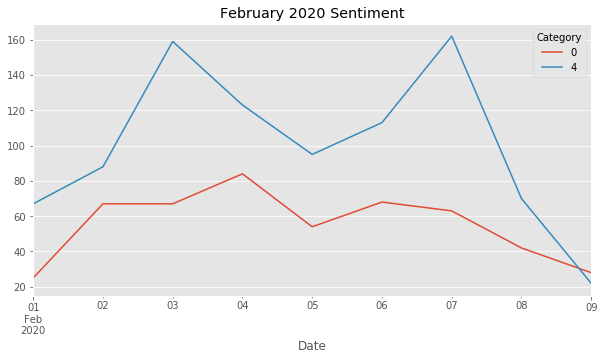

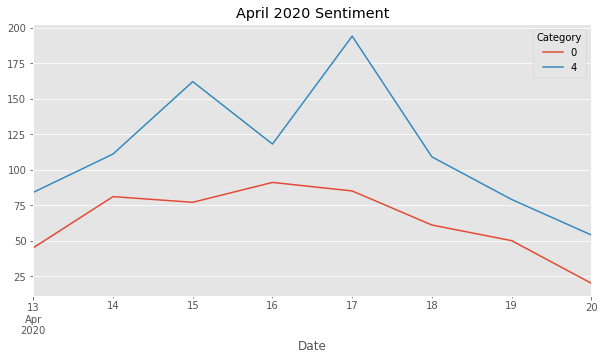

In [91]:
print ("\033[1m"+'Time plot of Sentiment from NUS'+"\033[0m")
Time_Plot('nus_sentiment.csv')

Time plot of Sentiment from SMU


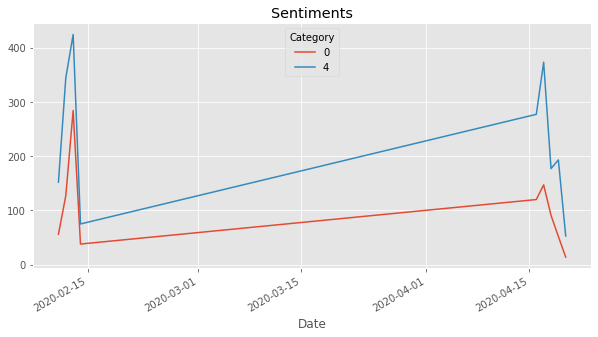

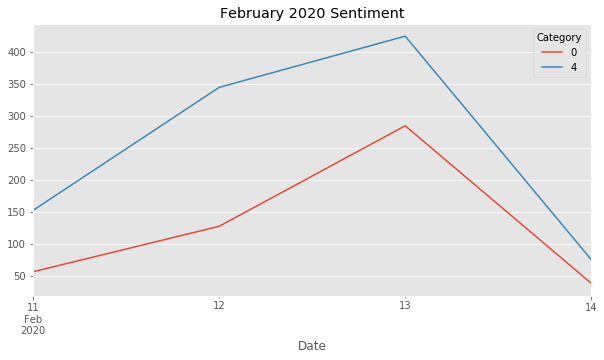

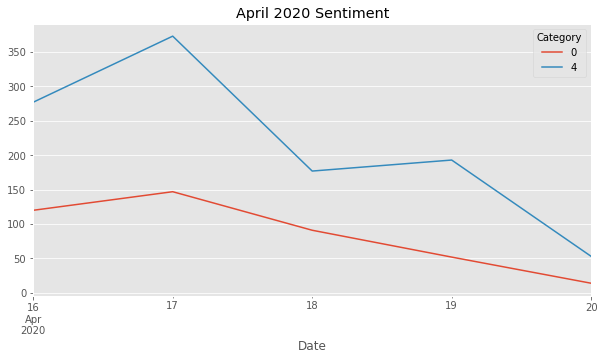

In [92]:
print ("\033[1m"+'Time plot of Sentiment from SMU'+"\033[0m")
Time_Plot('smu_sentiment.csv')

Time plot of Sentiment from Universities


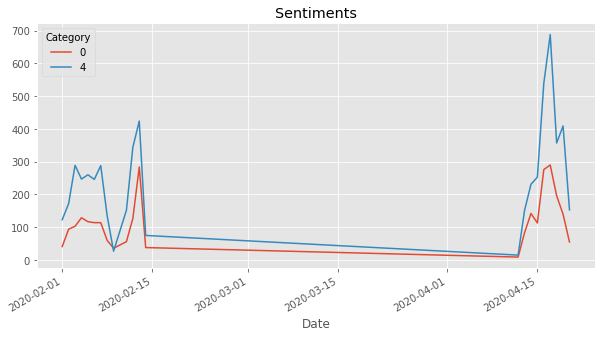

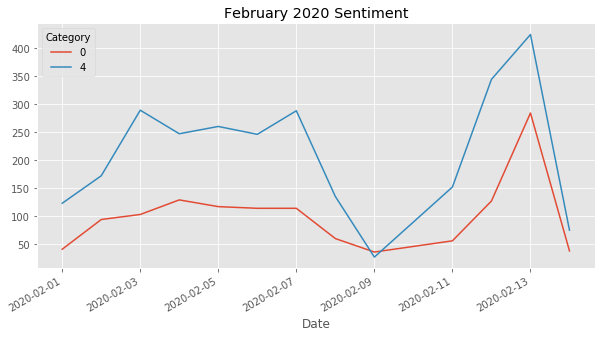

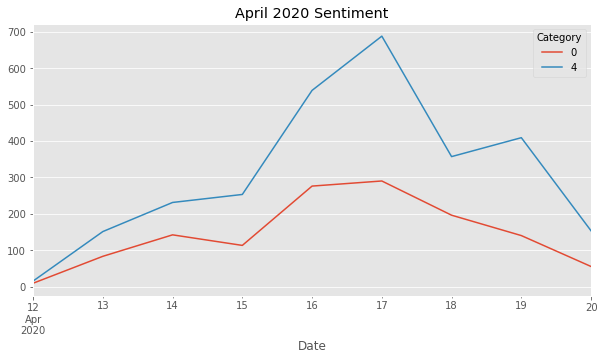

In [93]:
print ("\033[1m"+'Time plot of Sentiment from Universities'+"\033[0m")
Time_Plot('uni_sentiment.csv')

# Using Sentiment Intensity Analyzer to find positve and negative words

In [94]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import matplotlib.pyplot as plt
import re
import collections
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def SIA(file):
    words = re.findall(r'\w+', open(file).read().lower())
    stop_words = stopwords.words('english')
    f_words = []
    for w in words:
        if w not in stop_words:
            f_words.append(w)
        
    sid = SentimentIntensityAnalyzer()
    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]

    for word in f_words:
        if (sid.polarity_scores(word)['compound']) >= 0.5:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.5:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                
  
    freq_pos = FreqDist(pos_word_list)
    freq_neg = FreqDist(neg_word_list)
    freq_neu = FreqDist(neu_word_list)
    freq_com = FreqDist(f_words)
    
    plt.figure(figsize=(10,5))
    plt.title('\nTop 20 Positive Words')
    freq_pos.plot(20, cumulative=False, color = 'blue')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('\nTop 20 Negative Words')
    freq_neg.plot(20, cumulative=False, color = 'red')
    plt.show()   
    return 

20 most positive and negative words from NTU Tweets


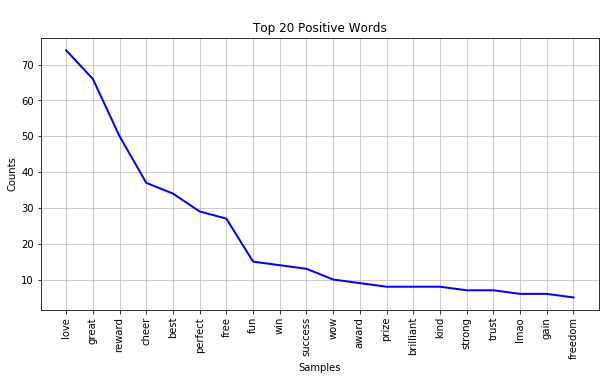

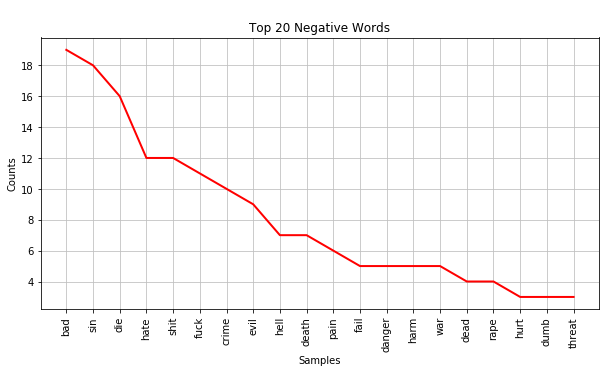

In [81]:
print ("\033[1m"+'20 most positive and negative words from NTU Tweets'+"\033[0m")
SIA('ntu_sentiment.csv')

20 most positive and negative words from NUS Tweets


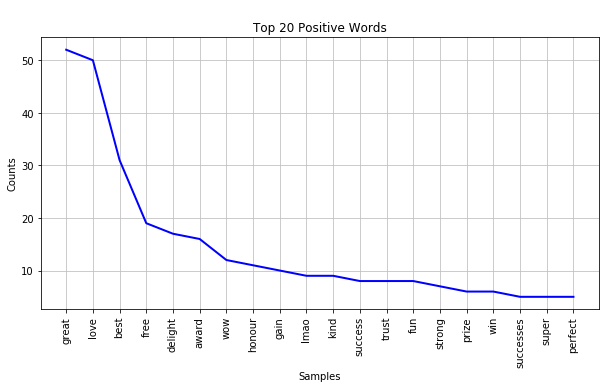

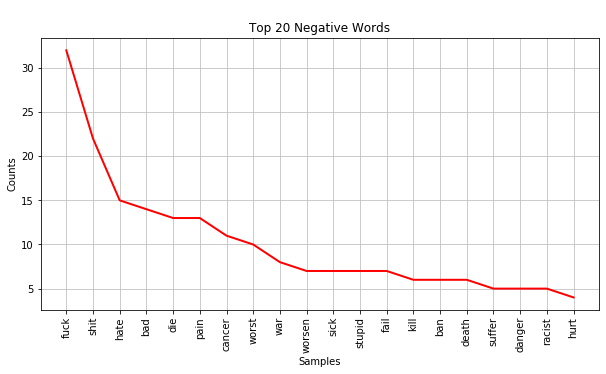

In [80]:
print ("\033[1m"+'20 most positive and negative words from NUS Tweets'+"\033[0m")
SIA('nus_sentiment.csv')

20 most positive and negative words from SMU Tweets


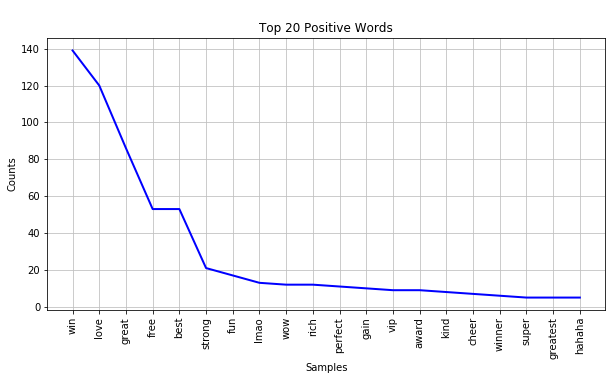

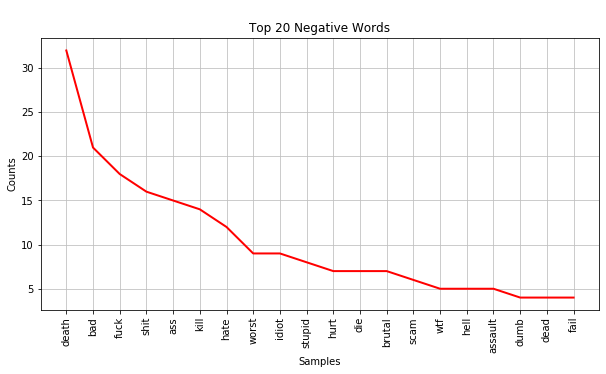

In [79]:
print ("\033[1m"+'20 most positive and negative words from SMU Tweets'+"\033[0m")
SIA('smu_sentiment.csv')

20 most positive and negative words from University Tweets


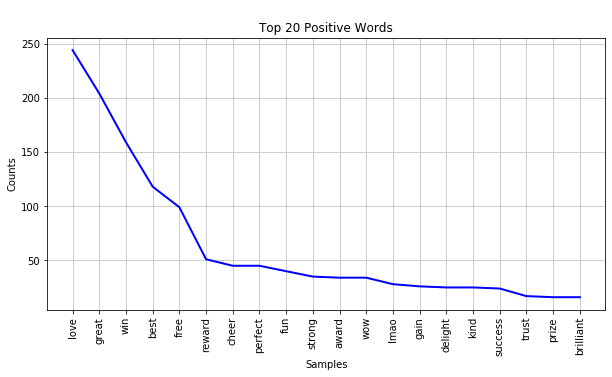

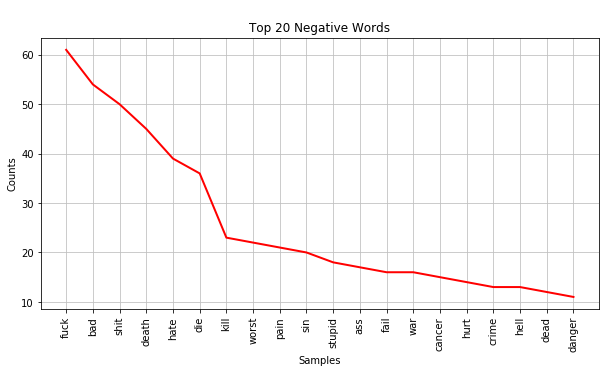

In [78]:
print ("\033[1m"+'20 most positive and negative words from University Tweets'+"\033[0m")
SIA('uni_sentiment.csv')

# Using word cloud to check for common words used

In [19]:
### PROGRAM TO GENERATE WORDCLOUD

### Importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import time

def wordcloud(file):
    df = pd.read_csv(file, encoding = "ISO-8859-1")
    df_neg= df[(df.Sentiment == 0)]
    df_pos= df[(df.Sentiment == 4)]

    comment_words = ' '
    stopwords = set(STOPWORDS) 
    stopwords.update (['nus','ntu','smu','student','nu','nan','sg','scse','king',
                       'one', 'go','chodi', 'game','thi','still','uconn','nation'
                       'school', 'singapor','team', 'dont team', 'minion', 'card',
                       'dont miss', 'dont', 'miss', 'win'])

    print ('Positive' )
    for val in df_pos.Tweet: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()      
        for words in tokens: 
            comment_words = comment_words + words + ' '        
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)   
    plt.show()

    # Starting for tweets with negative sentiments
    comment_words = ' '
    print ('Negative' )
    for val in df_neg.Tweet: 
        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()      
        for words in tokens: 
            comment_words = comment_words + words + ' '        
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    # plot the WordCloud image                        
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)   
    plt.show()

Word cloud from NTU Tweet

Positive


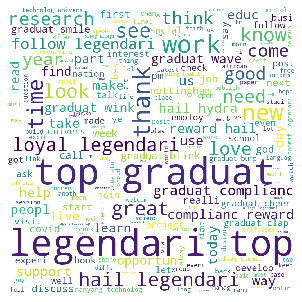

Negative


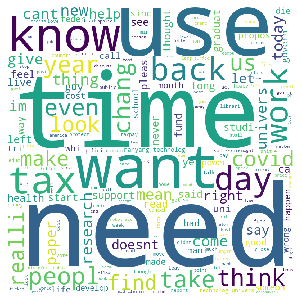

In [20]:
print ("\033[1m"+'Word cloud from NTU Tweet\n'+"\033[0m")
wordcloud('ntu_sentiment.csv')

Word cloud from NUS Tweet

Positive


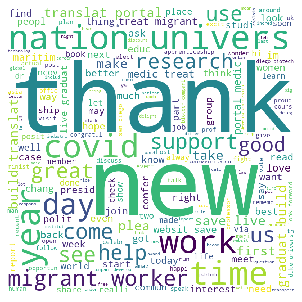

Negative


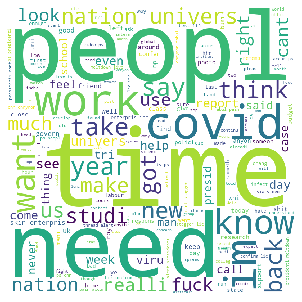

In [21]:
print ("\033[1m"+'Word cloud from NUS Tweet\n'+"\033[0m")
wordcloud('nus_sentiment.csv')

Word cloud from SMU Tweet

Positive


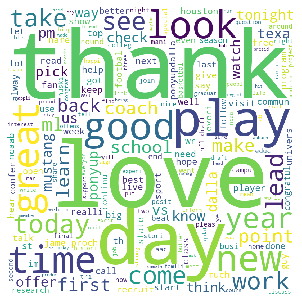

Negative


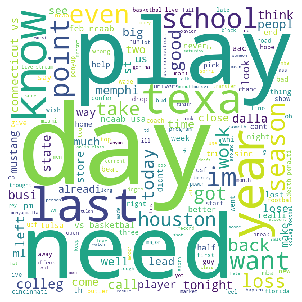

In [22]:
print ("\033[1m"+'Word cloud from SMU Tweet\n'+"\033[0m")
wordcloud('smu_sentiment.csv')

Word cloud from University Tweet

Positive


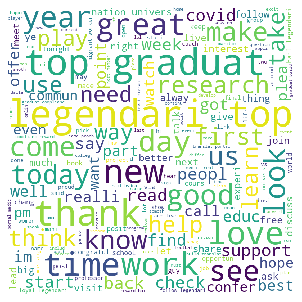

Negative


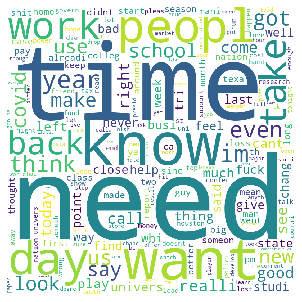

In [23]:
print ("\033[1m"+'Word cloud from University Tweet\n'+"\033[0m")
wordcloud('uni_sentiment.csv')